In [1]:
import os
import glob

from typing import Tuple, List, Union

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch import optim

import attn_dl
import attn_model
import scoring

In [2]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## Model Training

In [3]:
def ou_loss(output, target):
    loss = 0
    i = 0
    while i < len(output) - 1:
        loss += abs(target[i] + target[i+1] - output[i] - output[i+1])
        i += 2
    return loss/(len(output)/2.)

In [4]:
def spread_loss(output, target):
    loss = 0
    i = 0
    while i < len(output) - 1:
        loss += abs((target[i+1] - target[i]) - (output[i+1] - output[i]))
        i += 2
    return loss/(len(output)/2.)

In [5]:
# Roughly follows https://pytorch.org/tutorials/beginner/nn_tutorial.html#

# Model hyperparameters
num_epochs = 50
batch_size = 32
learning_rate = 0.0001

In [6]:
loss_func = F.smooth_l1_loss
model1, losses1 = attn_model.train_model(num_epochs, batch_size, learning_rate, heads = 8, depth = 2, loss_func= loss_func)

Training Model
tensor(137.1656, dtype=torch.float64)
50/50  [==============================] - 206.1s


In [12]:
_, x_train, y_train = attn_dl.load_vectorized_data('train')
_, x_validate, y_validate = attn_dl.load_vectorized_data('dev')
# Training error
train_diff = loss_func(model1(x_train), y_train).detach()
print("Training Error: ", train_diff)

## Validation Performance
# Total Loss on Validation Set
total_diff = loss_func(model1(x_validate), y_validate).detach()
print("Validation Error: ", total_diff)

# Error on test set
i_test, x_test, y_test = attn_dl.load_vectorized_data('test')
y_predicted = model1(x_test)
print("Test Error: ", loss_func(y_predicted, y_test))

Training Error:  tensor(8.7600, dtype=torch.float64)
Validation Error:  tensor(11.1514, dtype=torch.float64)
Test Error:  tensor(10.9705, dtype=torch.float64, grad_fn=<SmoothL1LossBackward>)


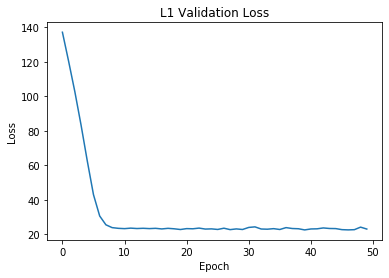

In [13]:
plt.title('L1 Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(losses1)
plt.show()

In [14]:
model2, losses2 = attn_model.train_model(num_epochs, batch_size, learning_rate, heads = 16, depth = 2, loss_func= loss_func)

Training Model
tensor(141.5089, dtype=torch.float64)
50/50  [==============================] - 323.3s


In [15]:
# Training error
train_diff = loss_func(model2(x_train), y_train).detach()
print("Training Error: ", train_diff)

## Validation Performance
# Total Loss on Validation Set
total_diff = loss_func(model2(x_validate), y_validate).detach()
print("Validation Error: ", total_diff)

# Error on test set
i_test, x_test, y_test = attn_dl.load_vectorized_data('test')
y_predicted = model2(x_test)
print("Test Error: ", loss_func(y_predicted, y_test))

Training Error:  tensor(8.6305, dtype=torch.float64)
Validation Error:  tensor(10.9853, dtype=torch.float64)
Test Error:  tensor(10.8093, dtype=torch.float64, grad_fn=<SmoothL1LossBackward>)


## Model Evaluation

In [34]:
# OVER/UNDER results at the CLOSE
header = '\t b won lost push  win% push%'
print(header)
print( '\t' + '-' * len(header))
for b in range(0, 35, 1):
    won, lost, pushed = scoring.score(model1, 'over/under', 'close', b)
    win_pct = won / (won + lost) if won + lost else 0
    push_pct = pushed / (won + lost + pushed)
    
    print(f'\t{b:>2}{won:>4}{lost:>5}{pushed:>5} {win_pct:.3f} {push_pct:.3f}')

	 b won lost push  win% push%
	-----------------------------
	 0 472  524    0 0.474 0.000
	 1 456  510   30 0.472 0.030
	 2 439  501   56 0.467 0.056
	 3 425  481   90 0.469 0.090
	 4 406  461  129 0.468 0.130
	 5 392  442  162 0.470 0.163
	 6 374  423  199 0.469 0.200
	 7 359  405  232 0.470 0.233
	 8 339  385  272 0.468 0.273
	 9 330  363  303 0.476 0.304
	10 313  347  336 0.474 0.337
	11 292  325  379 0.473 0.381
	12 271  303  422 0.472 0.424
	13 251  275  470 0.477 0.472
	14 226  246  524 0.479 0.526
	15 211  218  567 0.492 0.569
	16 190  195  611 0.494 0.613
	17 171  173  652 0.497 0.655
	18 156  155  685 0.502 0.688
	19 133  133  730 0.500 0.733
	20 120  114  762 0.513 0.765
	21 103   93  800 0.526 0.803
	22  85   75  836 0.531 0.839
	23  72   63  861 0.533 0.864
	24  56   49  891 0.533 0.895
	25  47   41  908 0.534 0.912
	26  39   37  920 0.513 0.924
	27  36   31  929 0.537 0.933
	28  29   25  942 0.537 0.946
	29  21   18  957 0.538 0.961
	30  17   15  964 0.531 0.968
	31  12  

In [35]:
# OVER/UNDER results at the OPEN
header = '\t b won lost push  win% push%'
print(header)
print('\t' + '-' * len(header))
for b in range(0, 30, 1):
    won, lost, pushed = scoring.score(model1, 'over/under', 'open', b)
    win_pct = won / (won + lost) if won + lost else 0
    push_pct = pushed / (won + lost + pushed)
    print(f'\t{b:>2}{won:>4}{lost:>5}{pushed:>5} {win_pct:.3f} {push_pct:.3f}')

	 b won lost push  win% push%
	-----------------------------
	 0 486  510    0 0.488 0.000
	 1 474  495   27 0.489 0.027
	 2 457  477   62 0.489 0.062
	 3 438  467   91 0.484 0.091
	 4 421  452  123 0.482 0.123
	 5 403  440  153 0.478 0.154
	 6 391  421  184 0.482 0.185
	 7 370  400  226 0.481 0.227
	 8 355  383  258 0.481 0.259
	 9 336  363  297 0.481 0.298
	10 322  338  336 0.488 0.337
	11 306  314  376 0.494 0.378
	12 279  282  435 0.497 0.437
	13 259  258  479 0.501 0.481
	14 237  235  524 0.502 0.526
	15 212  212  572 0.500 0.574
	16 191  194  611 0.496 0.613
	17 178  177  641 0.501 0.644
	18 161  153  682 0.513 0.685
	19 142  134  720 0.514 0.723
	20 121  113  762 0.517 0.765
	21 100   92  804 0.521 0.807
	22  81   73  842 0.526 0.845
	23  70   56  870 0.556 0.873
	24  57   46  893 0.553 0.897
	25  48   32  916 0.600 0.920
	26  41   28  927 0.594 0.931
	27  35   23  938 0.603 0.942
	28  27   21  948 0.562 0.952
	29  22   19  955 0.537 0.959


In [36]:
# SPREAD results at the CLOSE
header = '\t b won lost push  win% push%'
print(header)
print( '\t' + '-' * len(header))
for b in range(0, 20, 1):
    won, lost, pushed = scoring.score(model1, 'spread', 'close', b)
    win_pct = won / (won + lost) if won + lost else 0
    push_pct = pushed / (won + lost + pushed)
    print(f'\t{b:>2}{won:>4}{lost:>5}{pushed:>5} {win_pct:.3f} {push_pct:.3f}')

	 b won lost push  win% push%
	-----------------------------
	 0 495  501    0 0.497 0.000
	 1 450  453   93 0.498 0.093
	 2 404  402  190 0.501 0.191
	 3 357  362  277 0.497 0.278
	 4 304  318  374 0.489 0.376
	 5 259  279  458 0.481 0.460
	 6 227  245  524 0.481 0.526
	 7 199  217  580 0.478 0.582
	 8 178  175  643 0.504 0.646
	 9 144  136  716 0.514 0.719
	10 111  108  777 0.507 0.780
	11  92   77  827 0.544 0.830
	12  64   50  882 0.561 0.886
	13  48   32  916 0.600 0.920
	14  30   27  939 0.526 0.943
	15  18   15  963 0.545 0.967
	16  13    7  976 0.650 0.980
	17   9    5  982 0.643 0.986
	18   4    2  990 0.667 0.994
	19   0    1  995 0.000 0.999


In [37]:
# SPREAD results at the OPEN
header = '\t b won lost push  win% push%'
print(header)
print( '\t' + '-' * len(header))
for b in range(0, 20, 1):
    won, lost, pushed = scoring.score(model1, 'spread', 'open', b)
    win_pct = won / (won + lost) if won + lost else 0
    push_pct = pushed / (won + lost + pushed)
    print(f'\t{b:>2}{won:>4}{lost:>5}{pushed:>5} {win_pct:.3f} {push_pct:.3f}')

	 b won lost push  win% push%
	-----------------------------
	 0 501  495    0 0.503 0.000
	 1 452  442  102 0.506 0.102
	 2 397  393  206 0.503 0.207
	 3 346  344  306 0.501 0.307
	 4 297  309  390 0.490 0.392
	 5 256  266  474 0.490 0.476
	 6 222  233  541 0.488 0.543
	 7 198  198  600 0.500 0.602
	 8 167  163  666 0.506 0.669
	 9 141  125  730 0.530 0.733
	10 101   99  796 0.505 0.799
	11  80   72  844 0.526 0.847
	12  60   47  889 0.561 0.893
	13  43   28  925 0.606 0.929
	14  30   23  943 0.566 0.947
	15  19   15  962 0.559 0.966
	16  15    9  972 0.625 0.976
	17  11    4  981 0.733 0.985
	18   6    2  988 0.750 0.992
	19   2    1  993 0.667 0.997


# 16 Head Transformer Results

In [34]:
# OVER/UNDER results at the CLOSE
header = '\t b won lost push  win% push%'
print(header)
print( '\t' + '-' * len(header))
for b in range(0, 35, 1):
    won, lost, pushed = scoring.score(model2, 'over/under', 'close', b)
    win_pct = won / (won + lost) if won + lost else 0
    push_pct = pushed / (won + lost + pushed)
    
    print(f'\t{b:>2}{won:>4}{lost:>5}{pushed:>5} {win_pct:.3f} {push_pct:.3f}')

	 b won lost push  win% push%
	-----------------------------
	 0 472  524    0 0.474 0.000
	 1 456  510   30 0.472 0.030
	 2 439  501   56 0.467 0.056
	 3 425  481   90 0.469 0.090
	 4 406  461  129 0.468 0.130
	 5 392  442  162 0.470 0.163
	 6 374  423  199 0.469 0.200
	 7 359  405  232 0.470 0.233
	 8 339  385  272 0.468 0.273
	 9 330  363  303 0.476 0.304
	10 313  347  336 0.474 0.337
	11 292  325  379 0.473 0.381
	12 271  303  422 0.472 0.424
	13 251  275  470 0.477 0.472
	14 226  246  524 0.479 0.526
	15 211  218  567 0.492 0.569
	16 190  195  611 0.494 0.613
	17 171  173  652 0.497 0.655
	18 156  155  685 0.502 0.688
	19 133  133  730 0.500 0.733
	20 120  114  762 0.513 0.765
	21 103   93  800 0.526 0.803
	22  85   75  836 0.531 0.839
	23  72   63  861 0.533 0.864
	24  56   49  891 0.533 0.895
	25  47   41  908 0.534 0.912
	26  39   37  920 0.513 0.924
	27  36   31  929 0.537 0.933
	28  29   25  942 0.537 0.946
	29  21   18  957 0.538 0.961
	30  17   15  964 0.531 0.968
	31  12  

In [ ]:
# OVER/UNDER results at the OPEN
header = '\t b won lost push  win% push%'
print(header)
print('\t' + '-' * len(header))
for b in range(0, 30, 1):
    won, lost, pushed = scoring.score(model2, 'over/under', 'open', b)
    win_pct = won / (won + lost) if won + lost else 0
    push_pct = pushed / (won + lost + pushed)
    print(f'\t{b:>2}{won:>4}{lost:>5}{pushed:>5} {win_pct:.3f} {push_pct:.3f}')

	 b won lost push  win% push%
	-----------------------------
	 0 486  510    0 0.488 0.000
	 1 474  495   27 0.489 0.027
	 2 457  477   62 0.489 0.062
	 3 438  467   91 0.484 0.091
	 4 421  452  123 0.482 0.123
	 5 403  440  153 0.478 0.154
	 6 391  421  184 0.482 0.185
	 7 370  400  226 0.481 0.227
	 8 355  383  258 0.481 0.259
	 9 336  363  297 0.481 0.298
	10 322  338  336 0.488 0.337
	11 306  314  376 0.494 0.378
	12 279  282  435 0.497 0.437


In [ ]:
# SPREAD results at the CLOSE
header = '\t b won lost push  win% push%'
print(header)
print( '\t' + '-' * len(header))
for b in range(0, 20, 1):
    won, lost, pushed = scoring.score(model2, 'spread', 'close', b)
    win_pct = won / (won + lost) if won + lost else 0
    push_pct = pushed / (won + lost + pushed)
    print(f'\t{b:>2}{won:>4}{lost:>5}{pushed:>5} {win_pct:.3f} {push_pct:.3f}')

In [ ]:
# SPREAD results at the OPEN
header = '\t b won lost push  win% push%'
print(header)
print( '\t' + '-' * len(header))
for b in range(0, 20, 1):
    won, lost, pushed = scoring.score(model2, 'spread', 'open', b)
    win_pct = won / (won + lost) if won + lost else 0
    push_pct = pushed / (won + lost + pushed)
    print(f'\t{b:>2}{won:>4}{lost:>5}{pushed:>5} {win_pct:.3f} {push_pct:.3f}')